In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, Input, layers, optimizers, regularizers, callbacks, losses, metrics 
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
# FOR KAGGLE
train_images_dir = '../input/petfinder-pawpularity-score/train/'
test_images_dir = '../input/petfinder-pawpularity-score/test/'

# FOR LOCAL PC
# train_images_dir = './dataset/train/'
# test_images_dir = './dataset/test/'

In [4]:
train_df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
train_df.loc[:, 'filename'] = train_images_dir + train_df['Id'] + '.jpg'

test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
test_df.loc[:, 'filename'] = test_images_dir + test_df['Id'] + '.jpg'

In [5]:
X_train, X_val, y_train, y_val = train_test_split(train_df.loc[:, train_df.columns != 'Pawpularity'], train_df['Pawpularity'], test_size=0.2, random_state=42)

In [6]:
cols = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

In [7]:
img_size = (320, 320, 3)
BATCH_SIZE = 32

def augment_image(inputs, label=None):
    image = tf.image.random_flip_left_right(inputs[0])
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0.95, 1.05)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.95, 1.05)
    image = tf.image.random_hue(image, 0.05)
    return (image, inputs[1]), label

def parse_image(inputs, label=None):
    image_string = tf.io.read_file(inputs[0])
    image = tf.image.decode_jpeg(image_string, channels=img_size[2])
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, img_size[:2])
    return (image, inputs[1]), label

def get_dataset(inputs, label=None, shuffle=False, augment=False, repeat=False):
    dataset = tf.data.TFRecordDataset.from_tensor_slices((inputs, label))     
    dataset = dataset.map(parse_image, num_parallel_calls=4)
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=4)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(1024, reshuffle_each_iteration = True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(True)
    return dataset

In [8]:
train_dataset = get_dataset((X_train['filename'], X_train[cols]), y_train, shuffle=True, augment=True)
val_dataset = get_dataset((X_val['filename'], X_val[cols]), y_val)
test_dataset = get_dataset((test_df['filename'], test_df[cols]))

2021-12-19 19:49:30.648866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 19:49:30.750102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 19:49:30.750866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 19:49:30.753376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
img_augmentation = tf.keras.models.Sequential(
    [
        layers.RandomRotation(factor=1/32),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip('horizontal'),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

def build_model():
    # inputs
    image_input = Input(shape=img_size)
    tabular_input = Input(shape=(len(cols),))
    
    mobilenet = tf.keras.applications.MobileNetV3Small(include_top=False, weights="imagenet")
    # Freeze the pretrained weights
    mobilenet.trainable = False
    # Rebuild top
    x = mobilenet(image_input)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    flat_img = layers.Dense(64, activation="relu", name="features")(x)

    # tabular metadata processing
    y = layers.Dense(128, activation='relu')(tabular_input)
    y = layers.Dropout(0.3)(y)
    y = layers.Dense(64, activation='relu')(y)
    y = layers.Dropout(0.3)(y)

    # combining
    z = layers.Concatenate(name='concat')([flat_img, y])
    z = layers.Dense(32, activation='relu')(z)
    z = layers.Dropout(0.3)(z)
    z = layers.Dense(16, activation='relu')(z)
    output = layers.Dense(1)(z)
    # output = layers.Rescaling(100)(z)

    model = tf.keras.Model(
        inputs = (image_input, tabular_input),
        outputs=output
    )
    model.compile(optimizer=optimizers.Adam(), 
                  loss=losses.MeanSquaredError(), 
                  metrics=[metrics.RootMeanSquaredError()]
                 )
    return model

In [10]:
model = build_model()

6709248/6698480 [==============================] - 0s 0us/step


In [11]:
es = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.002, patience=10)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=5, min_lr=0.000001)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
#     steps_per_epoch=20,
#     use_multiprocessing=True,
#     callbacks=[es, reduce_lr]
)

Epoch 1/100


2021-12-19 19:49:37.879749: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-19 19:49:48.337694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 942 of 1024
2021-12-19 19:49:49.214834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2021-12-19 19:49:51.084258: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


248/248 [==============================] - 115s 381ms/step - loss: 618.2010 - root_mean_squared_error: 24.8636 - val_loss: 444.9302 - val_root_mean_squared_error: 21.0934
Epoch 2/100
248/248 [==============================] - 89s 324ms/step - loss: 445.9944 - root_mean_squared_error: 21.1186 - val_loss: 455.5911 - val_root_mean_squared_error: 21.3446
Epoch 3/100
248/248 [==============================] - 90s 328ms/step - loss: 449.2879 - root_mean_squared_error: 21.1964 - val_loss: 449.6078 - val_root_mean_squared_error: 21.2040
Epoch 4/100
248/248 [==============================] - 90s 327ms/step - loss: 444.7314 - root_mean_squared_error: 21.0887 - val_loss: 448.5503 - val_root_mean_squared_error: 21.1790
Epoch 5/100
248/248 [==============================] - 91s 330ms/step - loss: 442.1070 - root_mean_squared_error: 21.0263 - val_loss: 467.5411 - val_root_mean_squared_error: 21.6227
Epoch 6/100
248/248 [==============================] - 91s 329ms/step - loss: 439.8376 - root_mean_sq

2021-12-19 20:28:41.613197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1003 of 1024
2021-12-19 20:28:41.788715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 91s 326ms/step - loss: 424.0328 - root_mean_squared_error: 20.5921 - val_loss: 513.4326 - val_root_mean_squared_error: 22.6590
Epoch 21/100
248/248 [==============================] - 90s 330ms/step - loss: 424.5713 - root_mean_squared_error: 20.6051 - val_loss: 512.5302 - val_root_mean_squared_error: 22.6391
Epoch 22/100


2021-12-19 20:32:34.548678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 991 of 1024
2021-12-19 20:32:34.782471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 88s 313ms/step - loss: 423.9516 - root_mean_squared_error: 20.5901 - val_loss: 542.8110 - val_root_mean_squared_error: 23.2983
Epoch 23/100
248/248 [==============================] - 91s 329ms/step - loss: 426.4773 - root_mean_squared_error: 20.6513 - val_loss: 578.1575 - val_root_mean_squared_error: 24.0449
Epoch 24/100
248/248 [==============================] - 91s 327ms/step - loss: 423.6097 - root_mean_squared_error: 20.5818 - val_loss: 501.0579 - val_root_mean_squared_error: 22.3843
Epoch 25/100


2021-12-19 20:39:40.274897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 979 of 1024
2021-12-19 20:39:40.795633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 90s 321ms/step - loss: 421.9523 - root_mean_squared_error: 20.5415 - val_loss: 515.9444 - val_root_mean_squared_error: 22.7144
Epoch 26/100
248/248 [==============================] - 91s 329ms/step - loss: 424.0726 - root_mean_squared_error: 20.5930 - val_loss: 495.2444 - val_root_mean_squared_error: 22.2541
Epoch 27/100
248/248 [==============================] - 91s 326ms/step - loss: 422.3451 - root_mean_squared_error: 20.5510 - val_loss: 546.2146 - val_root_mean_squared_error: 23.3712
Epoch 28/100
248/248 [==============================] - 90s 330ms/step - loss: 420.7512 - root_mean_squared_error: 20.5122 - val_loss: 538.9700 - val_root_mean_squared_error: 23.2157
Epoch 29/100
248/248 [==============================] - 88s 316ms/step - loss: 422.1872 - root_mean_squared_error: 20.5472 - val_loss: 550.2986 - val_root_mean_squared_error: 23.4584
Epoch 30/100
248/248 [==============================] - 92s 335ms/step - loss: 422.0894 - root_mea

2021-12-19 20:50:25.761442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 981 of 1024
2021-12-19 20:50:26.108195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 334ms/step - loss: 421.6452 - root_mean_squared_error: 20.5340 - val_loss: 535.6784 - val_root_mean_squared_error: 23.1447
Epoch 32/100


2021-12-19 20:52:47.671845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 956 of 1024
2021-12-19 20:52:48.228041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 90s 319ms/step - loss: 420.2352 - root_mean_squared_error: 20.4996 - val_loss: 564.1326 - val_root_mean_squared_error: 23.7515
Epoch 33/100


2021-12-19 20:55:09.579430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1021 of 1024
2021-12-19 20:55:09.587214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 92s 331ms/step - loss: 420.5910 - root_mean_squared_error: 20.5083 - val_loss: 561.8539 - val_root_mean_squared_error: 23.7035
Epoch 34/100


2021-12-19 20:57:31.490314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1006 of 1024
2021-12-19 20:57:31.634007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 90s 323ms/step - loss: 423.5186 - root_mean_squared_error: 20.5796 - val_loss: 541.2827 - val_root_mean_squared_error: 23.2655
Epoch 35/100
248/248 [==============================] - 91s 332ms/step - loss: 420.3462 - root_mean_squared_error: 20.5023 - val_loss: 551.3999 - val_root_mean_squared_error: 23.4819
Epoch 36/100


2021-12-19 21:01:23.720713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 981 of 1024
2021-12-19 21:01:24.090689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 336ms/step - loss: 422.3323 - root_mean_squared_error: 20.5507 - val_loss: 470.4791 - val_root_mean_squared_error: 21.6905
Epoch 37/100
248/248 [==============================] - 90s 332ms/step - loss: 422.3183 - root_mean_squared_error: 20.5504 - val_loss: 541.4688 - val_root_mean_squared_error: 23.2695
Epoch 38/100


2021-12-19 21:04:27.931147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 977 of 1024
2021-12-19 21:04:28.280806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 90s 321ms/step - loss: 419.3832 - root_mean_squared_error: 20.4788 - val_loss: 551.4398 - val_root_mean_squared_error: 23.4828
Epoch 39/100
248/248 [==============================] - 89s 320ms/step - loss: 419.5199 - root_mean_squared_error: 20.4822 - val_loss: 593.0557 - val_root_mean_squared_error: 24.3527
Epoch 40/100


2021-12-19 21:07:26.834161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 981 of 1024
2021-12-19 21:07:27.173682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 336ms/step - loss: 420.6826 - root_mean_squared_error: 20.5105 - val_loss: 621.0639 - val_root_mean_squared_error: 24.9212
Epoch 41/100
248/248 [==============================] - 92s 336ms/step - loss: 420.4393 - root_mean_squared_error: 20.5046 - val_loss: 554.8361 - val_root_mean_squared_error: 23.5550
Epoch 42/100


2021-12-19 21:10:32.280180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 974 of 1024
2021-12-19 21:10:32.697110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 335ms/step - loss: 418.6616 - root_mean_squared_error: 20.4612 - val_loss: 542.1939 - val_root_mean_squared_error: 23.2851
Epoch 43/100


2021-12-19 21:12:54.195848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 966 of 1024
2021-12-19 21:12:54.672412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 331ms/step - loss: 419.2747 - root_mean_squared_error: 20.4762 - val_loss: 549.8214 - val_root_mean_squared_error: 23.4483
Epoch 44/100
248/248 [==============================] - 93s 338ms/step - loss: 419.8441 - root_mean_squared_error: 20.4901 - val_loss: 542.9324 - val_root_mean_squared_error: 23.3009
Epoch 45/100


2021-12-19 21:16:48.791427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 937 of 1024
2021-12-19 21:16:49.473375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 339ms/step - loss: 419.3040 - root_mean_squared_error: 20.4769 - val_loss: 532.3454 - val_root_mean_squared_error: 23.0726
Epoch 46/100


2021-12-19 21:19:10.692814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 838 of 1024
2021-12-19 21:19:12.170667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 336ms/step - loss: 418.8664 - root_mean_squared_error: 20.4662 - val_loss: 567.0532 - val_root_mean_squared_error: 23.8129
Epoch 47/100


2021-12-19 21:21:32.612645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 929 of 1024
2021-12-19 21:21:33.408086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 341ms/step - loss: 419.4028 - root_mean_squared_error: 20.4793 - val_loss: 584.5503 - val_root_mean_squared_error: 24.1775
Epoch 48/100


2021-12-19 21:23:54.515996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 907 of 1024
2021-12-19 21:23:55.434010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 338ms/step - loss: 419.4814 - root_mean_squared_error: 20.4812 - val_loss: 543.8698 - val_root_mean_squared_error: 23.3210
Epoch 49/100


2021-12-19 21:26:16.440820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 811 of 1024
2021-12-19 21:26:18.081365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 90s 315ms/step - loss: 418.6233 - root_mean_squared_error: 20.4603 - val_loss: 540.4922 - val_root_mean_squared_error: 23.2485
Epoch 50/100


2021-12-19 21:28:38.338575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 897 of 1024
2021-12-19 21:28:39.396270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 89s 316ms/step - loss: 419.7654 - root_mean_squared_error: 20.4882 - val_loss: 597.8986 - val_root_mean_squared_error: 24.4520
Epoch 51/100


2021-12-19 21:31:00.281433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 917 of 1024
2021-12-19 21:31:01.365334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 332ms/step - loss: 419.5455 - root_mean_squared_error: 20.4828 - val_loss: 558.1833 - val_root_mean_squared_error: 23.6259
Epoch 52/100


2021-12-19 21:33:22.195762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 922 of 1024
2021-12-19 21:33:23.644206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 327ms/step - loss: 419.4328 - root_mean_squared_error: 20.4801 - val_loss: 574.7422 - val_root_mean_squared_error: 23.9738
Epoch 53/100
248/248 [==============================] - 87s 318ms/step - loss: 421.4144 - root_mean_squared_error: 20.5284 - val_loss: 555.7482 - val_root_mean_squared_error: 23.5743
Epoch 54/100


2021-12-19 21:37:17.075194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 800 of 1024
2021-12-19 21:37:18.813079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 92s 323ms/step - loss: 418.0854 - root_mean_squared_error: 20.4471 - val_loss: 546.5331 - val_root_mean_squared_error: 23.3780
Epoch 55/100


2021-12-19 21:39:39.007776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 869 of 1024
2021-12-19 21:39:40.333506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 331ms/step - loss: 418.7890 - root_mean_squared_error: 20.4643 - val_loss: 520.1769 - val_root_mean_squared_error: 22.8074
Epoch 56/100


2021-12-19 21:42:00.942462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 858 of 1024
2021-12-19 21:42:02.214030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 330ms/step - loss: 419.2003 - root_mean_squared_error: 20.4744 - val_loss: 581.7259 - val_root_mean_squared_error: 24.1190
Epoch 57/100
248/248 [==============================] - 90s 329ms/step - loss: 422.0990 - root_mean_squared_error: 20.5450 - val_loss: 517.8697 - val_root_mean_squared_error: 22.7568
Epoch 58/100


2021-12-19 21:45:56.017530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 858 of 1024
2021-12-19 21:45:57.307947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 335ms/step - loss: 418.1599 - root_mean_squared_error: 20.4490 - val_loss: 542.9715 - val_root_mean_squared_error: 23.3017
Epoch 59/100
248/248 [==============================] - 91s 333ms/step - loss: 417.7303 - root_mean_squared_error: 20.4385 - val_loss: 568.3045 - val_root_mean_squared_error: 23.8391
Epoch 60/100


2021-12-19 21:49:52.397581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 858 of 1024
2021-12-19 21:49:54.622609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 91s 317ms/step - loss: 417.6894 - root_mean_squared_error: 20.4375 - val_loss: 537.5251 - val_root_mean_squared_error: 23.1846
Epoch 61/100


2021-12-19 21:52:14.284823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 734 of 1024
2021-12-19 21:52:16.940282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 331ms/step - loss: 415.8335 - root_mean_squared_error: 20.3920 - val_loss: 554.9352 - val_root_mean_squared_error: 23.5571
Epoch 62/100
248/248 [==============================] - 88s 317ms/step - loss: 418.9452 - root_mean_squared_error: 20.4682 - val_loss: 576.5809 - val_root_mean_squared_error: 24.0121
Epoch 63/100
248/248 [==============================] - 89s 323ms/step - loss: 417.7564 - root_mean_squared_error: 20.4391 - val_loss: 562.4651 - val_root_mean_squared_error: 23.7163
Epoch 64/100


2021-12-19 21:57:39.329417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 760 of 1024
2021-12-19 21:57:41.582644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 334ms/step - loss: 419.0845 - root_mean_squared_error: 20.4716 - val_loss: 579.2786 - val_root_mean_squared_error: 24.0682
Epoch 65/100


2021-12-19 22:00:01.232313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 809 of 1024
2021-12-19 22:00:02.980213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 336ms/step - loss: 417.6377 - root_mean_squared_error: 20.4362 - val_loss: 582.9070 - val_root_mean_squared_error: 24.1435
Epoch 66/100


2021-12-19 22:02:23.160283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 817 of 1024
2021-12-19 22:02:24.887990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 92s 325ms/step - loss: 418.7812 - root_mean_squared_error: 20.4641 - val_loss: 543.1219 - val_root_mean_squared_error: 23.3050
Epoch 67/100


2021-12-19 22:04:45.056932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 732 of 1024
2021-12-19 22:04:47.431826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 96s 335ms/step - loss: 416.5731 - root_mean_squared_error: 20.4101 - val_loss: 555.3890 - val_root_mean_squared_error: 23.5667
Epoch 68/100
248/248 [==============================] - 92s 333ms/step - loss: 416.5788 - root_mean_squared_error: 20.4103 - val_loss: 557.3892 - val_root_mean_squared_error: 23.6091
Epoch 69/100


2021-12-19 22:08:42.512948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 793 of 1024
2021-12-19 22:08:44.488092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 336ms/step - loss: 416.6759 - root_mean_squared_error: 20.4126 - val_loss: 578.3408 - val_root_mean_squared_error: 24.0487
Epoch 70/100


2021-12-19 22:11:04.436970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 788 of 1024
2021-12-19 22:11:06.980006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 96s 336ms/step - loss: 416.8398 - root_mean_squared_error: 20.4167 - val_loss: 534.2899 - val_root_mean_squared_error: 23.1147
Epoch 71/100
248/248 [==============================] - 91s 332ms/step - loss: 417.7187 - root_mean_squared_error: 20.4382 - val_loss: 554.5170 - val_root_mean_squared_error: 23.5482
Epoch 72/100


2021-12-19 22:15:02.284703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 777 of 1024
2021-12-19 22:15:04.344828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 336ms/step - loss: 417.6954 - root_mean_squared_error: 20.4376 - val_loss: 610.7240 - val_root_mean_squared_error: 24.7128
Epoch 73/100
248/248 [==============================] - 90s 330ms/step - loss: 417.2446 - root_mean_squared_error: 20.4266 - val_loss: 568.3935 - val_root_mean_squared_error: 23.8410
Epoch 74/100


2021-12-19 22:18:59.650199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 757 of 1024
2021-12-19 22:19:01.847096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 333ms/step - loss: 418.2454 - root_mean_squared_error: 20.4510 - val_loss: 557.4839 - val_root_mean_squared_error: 23.6111
Epoch 75/100


2021-12-19 22:21:21.585006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 680 of 1024
2021-12-19 22:21:24.465706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 96s 334ms/step - loss: 419.1796 - root_mean_squared_error: 20.4739 - val_loss: 553.0341 - val_root_mean_squared_error: 23.5167
Epoch 76/100
248/248 [==============================] - 91s 333ms/step - loss: 418.8244 - root_mean_squared_error: 20.4652 - val_loss: 543.9374 - val_root_mean_squared_error: 23.3225
Epoch 77/100
248/248 [==============================] - 89s 324ms/step - loss: 417.7434 - root_mean_squared_error: 20.4388 - val_loss: 535.9359 - val_root_mean_squared_error: 23.1503
Epoch 78/100
248/248 [==============================] - 96s 352ms/step - loss: 416.7861 - root_mean_squared_error: 20.4153 - val_loss: 554.6362 - val_root_mean_squared_error: 23.5507
Epoch 79/100
248/248 [==============================] - 96s 352ms/step - loss: 418.0675 - root_mean_squared_error: 20.4467 - val_loss: 550.1315 - val_root_mean_squared_error: 23.4549
Epoch 80/100
248/248 [==============================] - 96s 351ms/step - loss: 417.3769 - root_mea

2021-12-19 22:44:04.185702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 701 of 1024
2021-12-19 22:44:07.368402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 327ms/step - loss: 417.2956 - root_mean_squared_error: 20.4278 - val_loss: 533.3344 - val_root_mean_squared_error: 23.0940
Epoch 87/100
248/248 [==============================] - 92s 333ms/step - loss: 417.2452 - root_mean_squared_error: 20.4266 - val_loss: 502.8631 - val_root_mean_squared_error: 22.4246
Epoch 88/100


2021-12-19 22:48:00.470430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 734 of 1024
2021-12-19 22:48:03.368617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 97s 339ms/step - loss: 416.1878 - root_mean_squared_error: 20.4007 - val_loss: 567.4109 - val_root_mean_squared_error: 23.8204
Epoch 89/100
248/248 [==============================] - 93s 339ms/step - loss: 416.9677 - root_mean_squared_error: 20.4198 - val_loss: 560.8974 - val_root_mean_squared_error: 23.6833
Epoch 90/100


2021-12-19 22:51:59.495848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 733 of 1024
2021-12-19 22:52:02.640644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 97s 337ms/step - loss: 416.1327 - root_mean_squared_error: 20.3993 - val_loss: 536.3794 - val_root_mean_squared_error: 23.1599
Epoch 91/100
248/248 [==============================] - 93s 336ms/step - loss: 418.0348 - root_mean_squared_error: 20.4459 - val_loss: 562.4008 - val_root_mean_squared_error: 23.7150
Epoch 92/100
248/248 [==============================] - 93s 339ms/step - loss: 415.6110 - root_mean_squared_error: 20.3865 - val_loss: 516.1346 - val_root_mean_squared_error: 22.7186
Epoch 93/100
248/248 [==============================] - 90s 325ms/step - loss: 416.3088 - root_mean_squared_error: 20.4036 - val_loss: 541.9385 - val_root_mean_squared_error: 23.2796
Epoch 94/100
248/248 [==============================] - 93s 339ms/step - loss: 417.6403 - root_mean_squared_error: 20.4363 - val_loss: 557.5399 - val_root_mean_squared_error: 23.6123
Epoch 95/100


2021-12-19 23:02:59.790346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 715 of 1024
2021-12-19 23:03:03.269682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 98s 339ms/step - loss: 418.1852 - root_mean_squared_error: 20.4496 - val_loss: 584.9857 - val_root_mean_squared_error: 24.1865
Epoch 96/100
248/248 [==============================] - 93s 341ms/step - loss: 417.5599 - root_mean_squared_error: 20.4343 - val_loss: 567.5953 - val_root_mean_squared_error: 23.8243
Epoch 97/100
248/248 [==============================] - 94s 343ms/step - loss: 416.3384 - root_mean_squared_error: 20.4044 - val_loss: 517.3652 - val_root_mean_squared_error: 22.7457
Epoch 98/100
248/248 [==============================] - 92s 335ms/step - loss: 416.1508 - root_mean_squared_error: 20.3998 - val_loss: 518.5439 - val_root_mean_squared_error: 22.7716
Epoch 99/100


2021-12-19 23:11:38.153797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 669 of 1024
2021-12-19 23:11:42.012304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 100s 347ms/step - loss: 416.3603 - root_mean_squared_error: 20.4049 - val_loss: 569.7192 - val_root_mean_squared_error: 23.8688
Epoch 100/100
248/248 [==============================] - 91s 334ms/step - loss: 415.7041 - root_mean_squared_error: 20.3888 - val_loss: 544.0654 - val_root_mean_squared_error: 23.3252


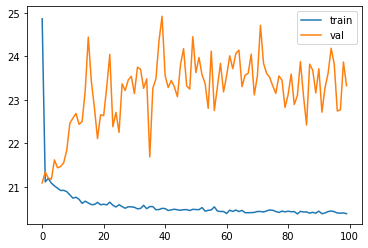

In [12]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.legend(['train', 'val'], loc='upper right')
plt.show()

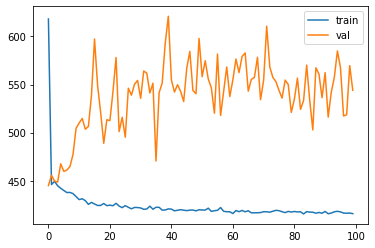

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [14]:
preds = model.predict(test_dataset)

In [15]:
submisson_df = test_df[['Id']]
submisson_df['Pawpularity'] = preds

In [16]:
submisson_df

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,19.188612
1,43a2262d7738e3d420d453815151079e,26.241337
2,4e429cead1848a298432a0acad014c9d,18.445230
3,80bc3ccafcc51b66303c2c263aa38486,18.653963
4,8f49844c382931444e68dffbe20228f4,18.354698
5,b03f7041962238a7c9d6537e22f9b017,37.779636
6,c978013571258ed6d4637f6e8cc9d6a3,14.689577
7,e0de453c1bffc20c22b072b34b54e50f,20.070110


In [17]:
submisson_df.to_csv('submission.csv', index=False)

In [18]:
model.save('/kaggle/working/multi_transfer_model.h5')